For context, Sprocket Central Pty Ltd is a long-standing KPMG client whom specialises in high-quality bikes and accessible cycling accessories to riders. Their marketing team is looking to boost business by analysing their existing customer dataset to determine customer trends and behaviour. 

Using the existing 3 datasets (Customer demographic, customer address and transactions) as a labelled dataset, please recommend which of these 1000 new customers should be targeted to drive the most value for the organisation. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xlrd

In [2]:
xlsx = pd.ExcelFile('KPMG_clean_data.xlsx')
df = pd.read_excel(xlsx, 'ExistingCustomerList')
transactions = pd.read_excel(xlsx, 'Transactions')
new_customers = pd.read_excel(xlsx, 'NewCustomerList')

Now we need to transform and impute our data in order to model the data to predict which new customers to focus on. 
Since our data is unlabeled, we will most likely use PCA and K-mean or KNN clusetering which new customers will likely a purchase.

In [3]:
df = df.merge(transactions, how='outer', on='customer_id')

In [4]:
df[df.transaction_id.isna()].head().T

,4962,5048,7905,11957,15285
customer_id,852,869,1373,2074,2660
first_name,Andie,Addia,Shaylynn,Roslyn,Hunt
last_name,Bonney,Abels,Epsley,Rawdall,Scollard
gender,Female,Female,Female,Female,Male
past_3_years_bike_related_purchases,37,7,3,90,44
job_title,Compensation Analyst,Account Representative I,Director of Sales,NaN,NaN
job_industry_category,Financial Services,Financial Services,Financial Services,Financial Services,Retail
wealth_segment,Affluent Customer,High Net Worth,Mass Customer,Mass Customer,High Net Worth
deceased_indicator,0,0,0,0,0
owns_car,1,1,1,0,1


We can see that there was some missing data from addresses that were not in our existing customer list. However, there don't seem to be any duplicates.

There are approximately 500 customers that do not have any information on purchases they made and 3 customers with no usable features. Since our goal is to determine what features to use in our marketing strategy, we will drop customer ids 4001, 4002, and 4003.

We should be okay to drop these as they make up less than 1% of our dataset.

We don't want to drop the other customers as it is possible they chose not to buy anything at all. That means their features will be useful for determining what market segments _not_ to focus on.

We have a total of 5 existing customers that were not in the customer list (customer_id 34, 4001, 4002, 4003, 5034). We will keep id 34 and 5034 as these customers have made transactions.

In [5]:
# drop customer_id 4001, 4002, and 4003 from df
drop_id = df[(df.customer_id == 4001) | (df.customer_id == 4002) | (df.customer_id == 4003)].index
df.drop(drop_id, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

We are going to assume that any purchases without a transaction_id was a customer who did not want to buy a product (ie. they did not order then cancel, they just simply did not order). We will then change fill in the following features with these values to reflect that:

- online_order = 0
- order_status = 0
- brand = NA
- product_line = NA
- product_class = NA
- product_size = NA
- list_price = 0
- standard_cost = 0
- profit = 0

In [6]:
df.loc[df.transaction_id.isna(), ['online_order']] = 0
df.loc[df.transaction_id.isna(), ['order_status']] = 0
df.loc[df.transaction_id.isna(), ['brand']] = 'NA'
df.loc[df.transaction_id.isna(), ['product_line']] = 'NA'
df.loc[df.transaction_id.isna(), ['product_class']] = 'NA'
df.loc[df.transaction_id.isna(), ['product_size']] = 'NA'
df.loc[df.transaction_id.isna(), ['list_price']] = 0
df.loc[df.transaction_id.isna(), ['standard_cost']] = 0
df.loc[df.transaction_id.isna(), ['profit']] = 0

# IMPUTE MISSING DATA

### ORDER_STATUS

In [7]:
df.loc[df.order_status == '1', ['brand', 'product_line', 'product_class', 'product_size', 'standard_cost', 'product_first_sold_date']].isna().sum()

brand                      0
product_line               0
product_class              0
product_size               0
standard_cost              0
product_first_sold_date    0
dtype: int64

In [8]:
df.loc[df.order_status == '0', ['brand', 'product_line', 'product_class', 'product_size', 'standard_cost', 'product_first_sold_date']].isna().sum()

brand                      0
product_line               0
product_class              0
product_size               0
standard_cost              0
product_first_sold_date    0
dtype: int64

Most of the missing features are from people who have approved orders. These features have list prices, so we can try and impute missing data by looking at what the most common brand, line, size, and class is at those price points.

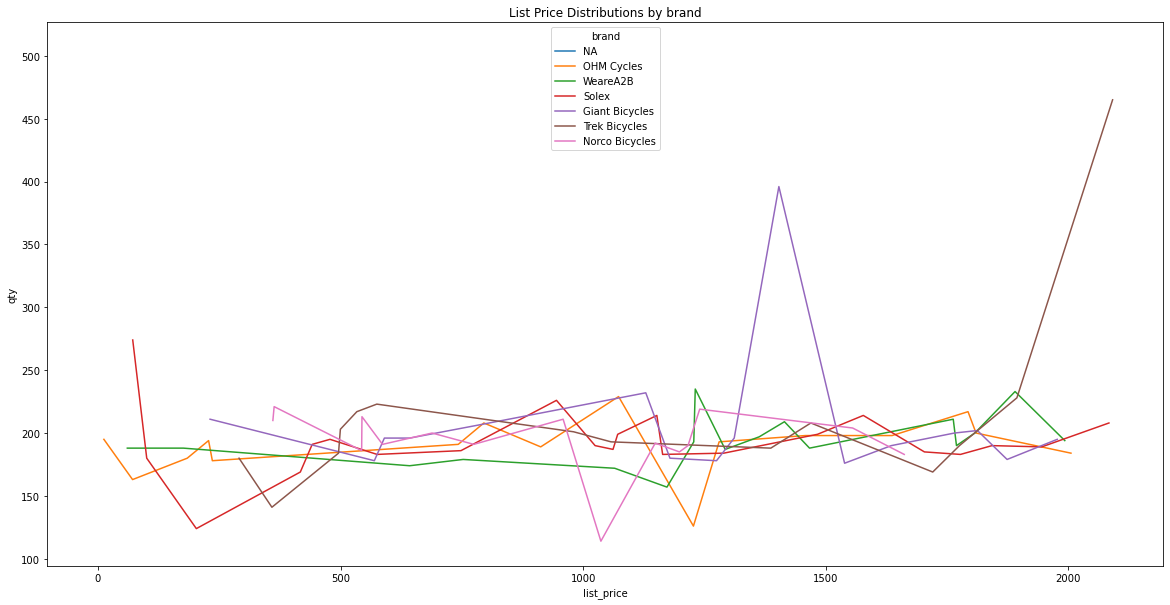

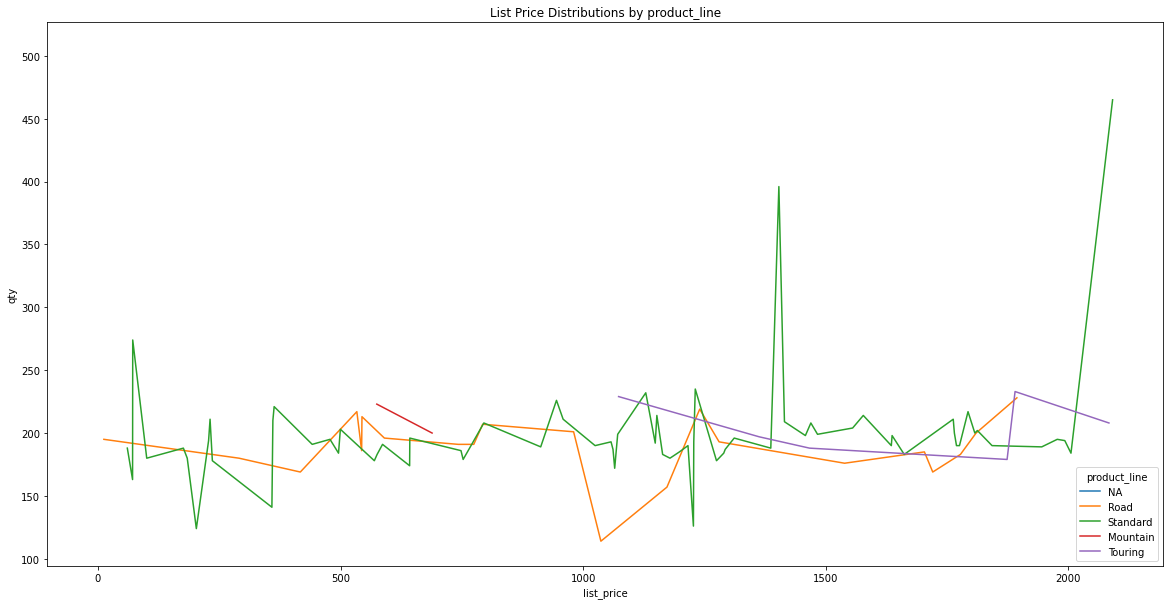

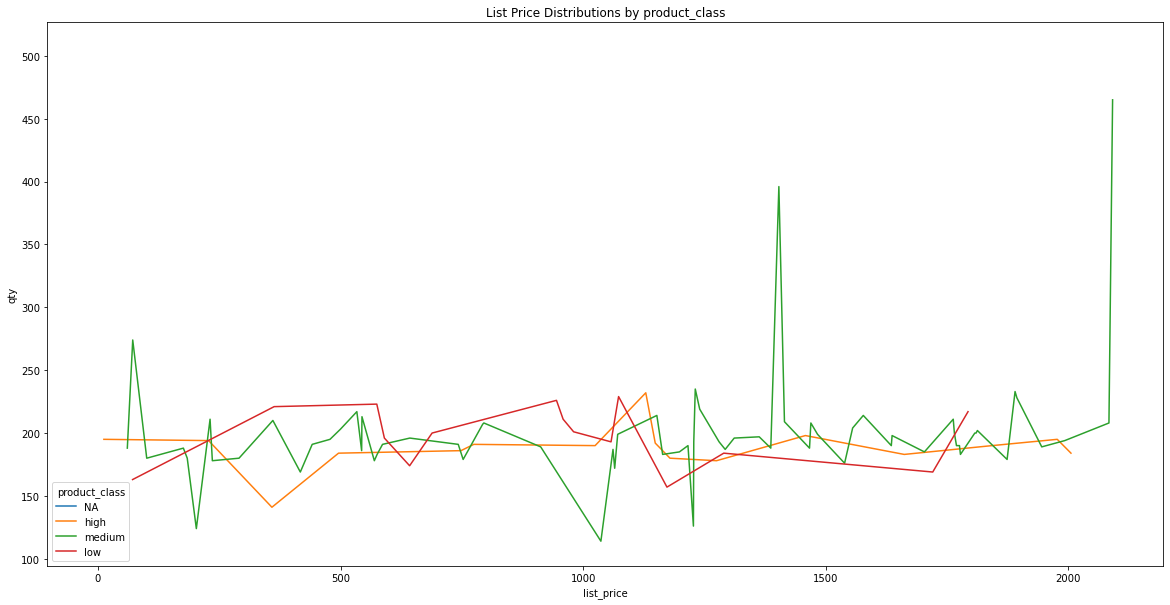

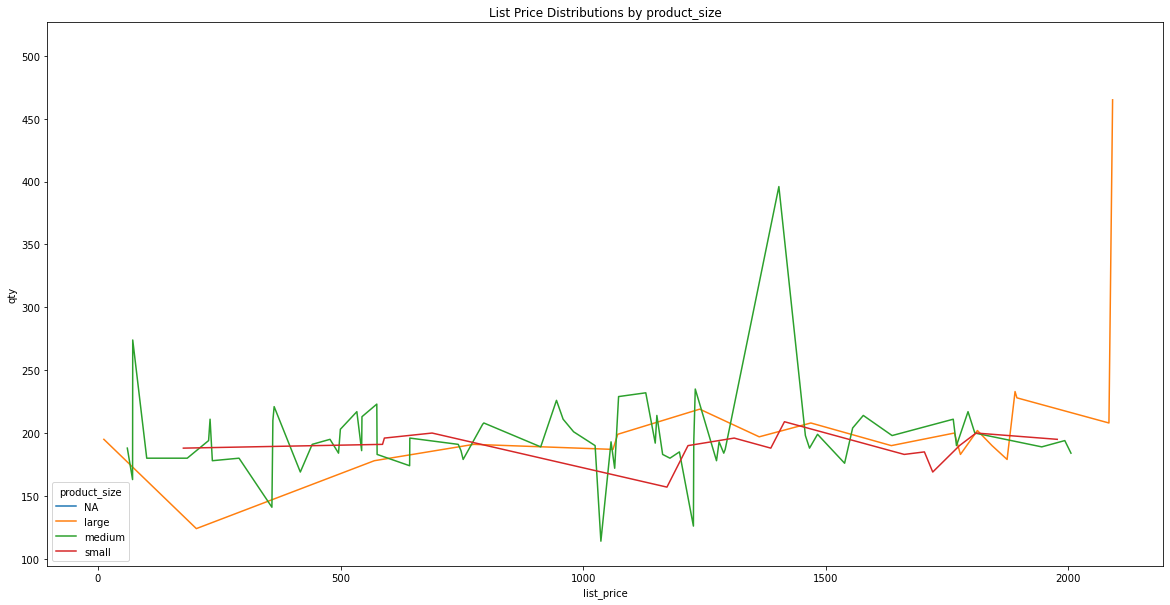

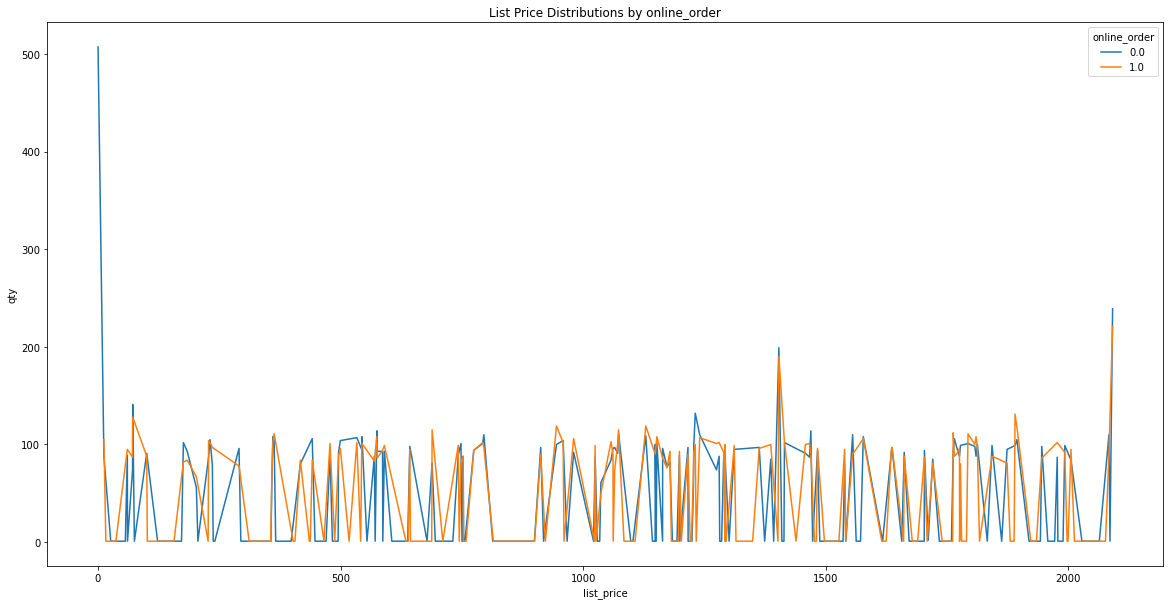

In [9]:
hues = ['brand', 'product_line', 'product_class', 'product_size', 'online_order']

for i in hues:
    transaction_grouped = df.loc[:, ['list_price', i]]
    transaction_grouped['qty'] = 1
    transaction_grouped = transaction_grouped.loc[:, ['list_price', i, 'qty']].groupby(['list_price', i]).count().reset_index()
    fig, axes = plt.subplots(1, 1, figsize=(20,10))
    sns.lineplot(data = transaction_grouped, x = 'list_price', y='qty', hue=i)
    plt.title(f'List Price Distributions by {i}')
    plt.show()

### ONLINE_ORDER

Online and physical orders are pretty evenly distributed across list prices so we can impute this by either backward or forward filling without changing the distribution too much.

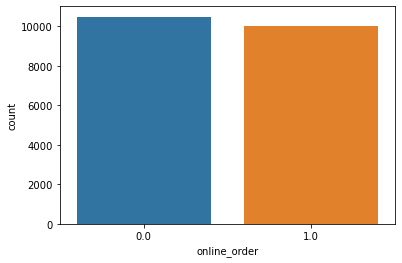

In [10]:
df['online_order'] = df.online_order.fillna(method='ffill')

sns.countplot(data=df, x='online_order')
plt.show()

#### BRAND, PRODUCT_LINE, PRODUCT_CLASS, PRODUCT_SIZE, STANDARD_COST

Based on the graph above that at certain price points, specific products are more or less likely to sell at certain price points. It would be tedious to individually set ranges and try to impute the data manually. Instead, we can sort the values in order of list price and impute the data that way. This will also keep profit margins consistent by list price and standard cost.

In [11]:
df.sort_values(by='list_price', ascending=False, inplace=True)

df['brand'] = df.brand.fillna(method='ffill')
df['product_line'] = df.product_line.fillna(method='ffill')
df['product_class'] = df.product_class.fillna(method='ffill')
df['product_size'] = df.product_size.fillna(method='ffill')
df['standard_cost'] = df.standard_cost.fillna(method='ffill')

# sort transactions by transaction_id again
df.sort_values(by='customer_id', inplace=True)

In [12]:
# update profits
df['profit'] = df['list_price'] - df['standard_cost']

In [13]:
# change losses to 0
df.loc[df.profit < 0, 'profit'] = 0

### JOB_TITLE AND JOB_INDUSTRY_CATEGORY

There are about 500-600 data points missing for both job title and job industry categories. Because we don't know what positions these are, we don't necessarily want to delete these from our datasets. Instead of null values, we will fill forward fill on this dataset instead.

In [14]:
# fill in missing values using forward fill
df['job_title'] = df.job_title.fillna(method='ffill')
df['job_industry_category'] = df.job_industry_category.fillna(method='ffill')

### GENDER

In [15]:
#change U to NAN values
df.loc[df.gender == 'U', 'gender'] = np.nan

# fill in missing values using forward fill
df['gender'] = df.gender.fillna(method='ffill')

### IMPUTING TENURE AND AGE

In [16]:
# fill in missing values using forward fill
df['tenure'] = df.tenure.fillna(method='ffill')
df['age'] = df.age.fillna(method='ffill')

### ADDRESSES

There are 31 customers that did not provide an address. It is possible that these customers do not have an Australian address and our visitors from out of the country. Instead of imputing this information, we will assume that these are visitors and drop them and focus on the local market segment. This is loss of data is still less than 1% of the whole dataset.

In [17]:
drop_visitors = df[df.address.isna()].index
df.drop(drop_visitors, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

### WEALTH_SEGMENT, DECEASED_INDICATOR, OWNS_CAR

In [18]:
df['wealth_segment'] = df.wealth_segment.fillna(method='ffill')
df['deceased_indicator'] = df.deceased_indicator.fillna(method='ffill')
df['owns_car'] = df.owns_car.fillna(method='ffill')

### PAST 3 YEARS BIKE PURCHASES

Since, the median and mean of bike purchases are close enough to one another, we will use this to impute

In [19]:
df.past_3_years_bike_related_purchases.describe()

count    20466.000000
mean        48.770449
std         28.639713
min          0.000000
25%         24.000000
50%         48.000000
75%         73.000000
max         99.000000
Name: past_3_years_bike_related_purchases, dtype: float64

In [20]:
# fill bike purchases with the median
df.loc[df.past_3_years_bike_related_purchases.isna(), 'past_3_years_bike_related_purchases'] = df.past_3_years_bike_related_purchases.median()

# NEW CUSTOMERS 
We will need to impute any missing data and may need to group values together while dropping others.

#### GENDER

Let's impute the unknown genders using a forward fill.

In [21]:
new_customers.loc[new_customers.gender == 'U', 'gender'] = np.nan
new_customers['gender'] = new_customers.gender.fillna(method='ffill')

#### JOB TITLE AND JOB CATEGORY

In [22]:
# impute missing job titles and categories
new_customers['job_title'] = new_customers.job_title.fillna(method='ffill')
new_customers['job_industry_category'] = new_customers.job_industry_category.fillna(method='ffill')

#### AGE

In [23]:
new_customers['age'] = new_customers.age.fillna(method='ffill')

In [24]:
new_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   first_name                           1000 non-null   object
 1   last_name                            971 non-null    object
 2   gender                               1000 non-null   object
 3   past_3_years_bike_related_purchases  1000 non-null   int64 
 4   job_title                            1000 non-null   object
 5   job_industry_category                1000 non-null   object
 6   wealth_segment                       1000 non-null   object
 7   deceased_indicator                   1000 non-null   object
 8   owns_car                             1000 non-null   object
 9   tenure                               1000 non-null   object
 10  address                              1000 non-null   object
 11  postcode                             1000 no

In [25]:
# save this as another dataset
with pd.ExcelWriter('KPMG_clean_data_imputed.xlsx') as writer:  
    df.to_excel(writer, sheet_name='ExistingCustomerList', index=False)
    #transactions.to_excel(writer, sheet_name='Transactions', index=False)
    new_customers.to_excel(writer, sheet_name='NewCustomerList', index=False)

# TRANSFORMING THE DATA

Before we transform the data, let's drop the following features and save this as df1:

- first name as we don't need this for our analysis; customer_id is enough
- last name as we don't need this for our analysis; customer_id is enough
- transaction id as we don't need this for our analysis; customer_id is enough
- product id as we don't need this for our analysis; customer_id is enough
- address (too granular and we already have this aggregated by remoteness)
- postcode (too granular and we already have this aggregated by remoteness)
- country (since all addresses are in Australia)

In [26]:
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler

In [27]:
def skewness_score(data, func):
    
    #create a copy of df
    scaledf = data.copy()
    
    for i in data.columns:
        if (data[i].agg(['skew'])[0] > 0.5) | (data[i].agg(['skew'])[0] < -0.5):
            scale = func(df[i])
            if func == boxcox:
                scaledf[i] = scale[0]
            else:
                scaledf[i] = scale

    # measure for skewness
    print(scaledf.agg(['skew']).T)
    return scaledf

In [28]:
df1 = df.drop(['first_name', 'last_name', 'transaction_id', 'product_id', 'address', 'postcode', 'country',
              'transaction_date', 'product_first_sold_date'], axis=1)

In [29]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,20475.0,1789.447668,1044.799587,1.0,887.000,1783.00,2677.50,4000.00
past_3_years_bike_related_purchases,20475.0,48.770110,28.633422,0.0,24.000,48.00,73.00,99.00
deceased_indicator,20475.0,0.000440,0.020962,0.0,0.000,0.00,0.00,1.00
owns_car,20475.0,0.503297,0.500001,0.0,0.000,1.00,1.00,1.00
property_valuation,20475.0,7.515995,2.825313,1.0,6.000,8.00,10.00,12.00
online_order,20475.0,0.489084,0.499893,0.0,0.000,0.00,1.00,1.00
order_status,20475.0,0.966545,0.179827,0.0,1.000,1.00,1.00,1.00
list_price,20475.0,1080.349261,600.783547,0.0,574.640,1151.96,1577.53,2091.47
standard_cost,20475.0,542.416561,410.417769,0.0,211.370,459.71,778.69,1759.85
profit,20475.0,537.938320,494.504913,0.0,131.195,437.46,827.16,1702.55


In [30]:
df1.agg(['skew', 'kurtosis']).T

,skew,kurtosis
customer_id,0.043092,-1.146837
past_3_years_bike_related_purchases,0.057076,-1.181198
deceased_indicator,47.668998,2270.555165
owns_car,-0.013188,-2.000021
property_valuation,-0.641506,-0.325848
online_order,0.043677,-1.998288
order_status,-5.189323,24.931505
list_price,-0.130442,-1.093849
standard_cost,0.856676,0.266897
profit,0.869970,-0.367749


Based on the skew of the data, we need to transform anything with a skewness score greater than +/- 0.5. We will try the following transformations:

 - standardization
 - min-max scaling
 - squareroot
 - yeo-johnson

In [31]:
num_features = ['past_3_years_bike_related_purchases', 'list_price', 'standard_cost', 'profit']

In [32]:
# 'deceased_indicator', 'owns_car', 'property_valuation', 'online_order', 'order_status',

In [33]:
skewed_df = df1.loc[:, num_features]

In [34]:
# square root transformation
sqrtdf = skewness_score(skewed_df, np.sqrt)

                                         skew
past_3_years_bike_related_purchases  0.057076
list_price                          -0.130442
standard_cost                       -0.089593
profit                               0.205851


All numerical features were transformed, however property valuations were made worse.

In [35]:
pt = PowerTransformer(method='yeo-johnson')
pt.fit(skewed_df)

yj_arr= pt.transform(skewed_df)
yj_df = pd.DataFrame(yj_arr, columns=num_features)

yj_df.agg(['skew', 'kurtosis']).T

,skew,kurtosis
past_3_years_bike_related_purchases,-0.245827,-1.010741
list_price,-0.449968,-0.771229
standard_cost,-0.159651,-0.498100
profit,-0.141618,-0.859970


In [36]:
skewed_df_cols = skewed_df.columns

In [37]:
scaler = MinMaxScaler()
scaler.fit(skewed_df)
minmax_data = scaler.transform(skewed_df)
pd.DataFrame(minmax_data, columns = skewed_df_cols).agg(['skew', 'kurtosis']).T

,skew,kurtosis
past_3_years_bike_related_purchases,0.057076,-1.181198
list_price,-0.130442,-1.093849
standard_cost,0.856676,0.266897
profit,0.869970,-0.367749


In [38]:
scaler = StandardScaler()
scaler.fit(skewed_df)
ss_data = scaler.transform(skewed_df)
pd.DataFrame(ss_data, columns = skewed_df_cols).agg(['skew', 'kurtosis']).T

,skew,kurtosis
past_3_years_bike_related_purchases,0.057076,-1.181198
list_price,-0.130442,-1.093849
standard_cost,0.856676,0.266897
profit,0.869970,-0.367749


Yeo-Johnson transformed the dataset the best, so we will use this and incorporate the data back into df1. But first let's turn all categorical variables into dummy variables.

In [39]:
cat_df = df1.loc[:, df1.columns[~df1.columns.isin(num_features)]]
cat_df = cat_df.iloc[:, 1:]
dummy_df = pd.get_dummies(cat_df, columns = cat_df.columns, drop_first = False)

In [40]:
df_final = pd.concat([dummy_df, yj_df], axis=1)
df_final.insert(0, 'customer_id', list(df1.customer_id))

## TRANSFORM NEW CUSTOMERS

In [50]:
new_customers1 = new_customers.drop(['first_name', 'last_name', 'address', 'postcode', 'country'], axis=1)
new_customers1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   gender                               1000 non-null   object
 1   past_3_years_bike_related_purchases  1000 non-null   int64 
 2   job_title                            1000 non-null   object
 3   job_industry_category                1000 non-null   object
 4   wealth_segment                       1000 non-null   object
 5   deceased_indicator                   1000 non-null   object
 6   owns_car                             1000 non-null   object
 7   tenure                               1000 non-null   object
 8   state                                1000 non-null   object
 9   property_valuation                   1000 non-null   int64 
 10  age                                  1000 non-null   object
 11  region                               1000 no

In [69]:
nc_num_features = ['past_3_years_bike_related_purchases']
nc_skewed_df = new_customers1.loc[:, nc_num_features]
nc_skewed_df = np.reshape(np.array(nc_skewed_df), (-1,1))

In [71]:
pt = PowerTransformer(method='yeo-johnson')
pt.fit(nc_skewed_df)

yj_arr= pt.transform(nc_skewed_df)
yj_df = pd.DataFrame(yj_arr, columns=nc_num_features)

yj_df.agg(['skew', 'kurtosis']).T

,skew,kurtosis
past_3_years_bike_related_purchases,-0.284982,-0.958092


In [75]:
cat_df = new_customers1.loc[:, new_customers1.columns[~new_customers1.columns.isin(nc_num_features)]]
cat_df = cat_df.iloc[:, 1:]
dummy_df = pd.get_dummies(cat_df, columns = cat_df.columns, drop_first = False)

In [76]:
new_customers_final = pd.concat([dummy_df, yj_df], axis=1)

# MODEL REVIEW

In [42]:
from pycaret.classification import *

In [43]:
def get_best_model(data):
    
    clf1 = setup(data, target = data.columns[-1], silent = True, verbose = False)
    #compare the models
    top5 = compare_models(n_select = 3) 
    #find the best model
    best = automl(optimize = 'Accuracy')
    
    print(best)
    
    return None